# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:7'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

# Text data preparation

Let's read tinyshakespeare.txt

In [2]:
CONTEXT_SIZE = 32

In [3]:
from spiky.util.text_snippet_sampler import TextSnippetSampler

snippet_sampler = TextSnippetSampler('tinyshakespeare.txt', CONTEXT_SIZE + 1, 1000, device)

In [4]:
snippet_sampler.sample_training_batch(2)

tensor([[104, 105, 115,  32, 121, 111, 117, 116, 104,  59,  10,  70, 111, 114,
          32, 121, 111, 117, 110, 103,  32, 104, 111, 116,  32,  99, 111, 108,
         116, 115,  32,  98, 101],
        [105, 110,  32, 102, 105, 101, 114, 121,  32, 102, 108, 111, 111, 100,
         115,  44,  32, 111, 114,  32, 116, 111,  32, 114, 101, 115, 105, 100,
         101,  10,  73, 110,  32]], device='cuda:7', dtype=torch.int32)

In [5]:
snippet_sampler.batch_to_text(snippet_sampler.sample_training_batch(4))

['of Rome tomorrow\nSet down our hos',
 'US:\nI paint him in the character.',
 ' conies after rain, and revel all',
 'on,\nTo know our further pleasure ']

In [6]:
for test_batch in snippet_sampler.testing_batches_iterator(4):
    print(snippet_sampler.batch_to_text(test_batch))
    break

['IZABETH:\nAnd wilt thou learn of m', 'in; but quickly now.\n\nServant:\nWh', ' lust,\nRelease my brother; and, a', 'row.\n\nDORSET:\nI will not rise, un']


# Baseline character transformer

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CharTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int = 256,
        d_model: int = 128,
        n_heads: int = 4,
        num_layers: int = 6,
        max_len: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len

        # Token embedding: fixed, random in [-1, 1], not trainable
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.token_emb.weight.data.uniform_(-1.0, 1.0)
        self.token_emb.weight.requires_grad_(False)

        # Positional embedding: trainable
        self.pos_emb = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.out = nn.Linear(d_model, vocab_size)

    def _causal_mask(self, seq_len: int, device):
        # [C, C] mask, True entries are masked (no attention)
        mask = torch.triu(
            torch.ones(seq_len, seq_len, device=device, dtype=torch.bool),
            diagonal=1,
        )
        return mask

    def forward(self, x, return_all_logits=False):
        B, C = x.shape
        device = x.device
        pos = torch.arange(C, device=device).unsqueeze(0)

        h = self.token_emb(x) + self.pos_emb(pos)
        src_mask = self._causal_mask(C, device)
        h_enc = self.encoder(h, mask=src_mask)          # [B, C, d_model]

        logits = self.out(h_enc)                         # [B, C, vocab]
        if return_all_logits:
            return logits
        return logits[:, -1, :]                          # [B, vocab] for generation

In [51]:
baseline_net = CharTransformer(max_len=CONTEXT_SIZE)
baseline_net.to(device)
x = torch.randint(0, 256, (4, CONTEXT_SIZE), dtype=torch.long, device=device)
logits = baseline_net(x) 
probs = baseline_net(x, True)
logits, probs

(tensor([[ 0.4703,  0.3021,  0.7887,  ..., -0.6848, -0.1082, -0.2524],
         [ 0.6393,  0.2416,  0.3283,  ..., -0.3723, -0.2050, -0.2345],
         [ 0.5373,  0.3551,  0.7443,  ..., -0.7050,  0.3220,  0.1304],
         [ 0.7908,  0.8072,  0.8351,  ..., -0.4384, -0.3285, -0.1200]],
        device='cuda:7', grad_fn=<SliceBackward0>),
 tensor([[[-0.5440,  1.2807,  0.1672,  ..., -0.1953,  0.7591, -0.6948],
          [ 0.0478,  0.6226,  0.8791,  ..., -0.4849, -0.1464,  0.4007],
          [-0.4498,  1.3022,  0.5089,  ..., -0.3987,  0.3241, -0.3806],
          ...,
          [-0.2708,  0.0724,  0.9306,  ..., -0.8902,  0.0163, -0.4721],
          [ 1.0709,  0.3446,  0.9421,  ..., -0.8391,  0.0543, -0.0629],
          [ 0.4380,  0.4824,  0.8861,  ..., -0.5766, -0.1046, -0.1250]],
 
         [[-0.2255,  0.4895,  0.4614,  ..., -0.0066, -0.1291, -0.1613],
          [ 0.4769, -0.0155,  0.8630,  ...,  0.0099, -0.2903,  0.6479],
          [-0.0108,  0.1276, -0.2786,  ...,  0.8275, -0.2438,  0.9889

In [52]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD

batch_size = 128

def generate_text(model, prefix, length, device):
    # encode prefix -> list of ints 0..255
    ctx = list(prefix.encode("utf-8"))

    for _ in range(length):
        trunc_ctx = ctx[-model.max_len:]
        x = torch.tensor(trunc_ctx, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
        logits = model(x)                    # [1, 256]
        probs = torch.softmax(logits, dim=-1)[0]
        next_id = torch.multinomial(probs, 1).item()
        ctx.append(next_id)

    return bytes(ctx).decode("latin1", errors="ignore")

def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in sampler.testing_batches_iterator(B):   # [B, C]
            inp = batch[:, :-1]          # [B, C-1]
            tgt = batch[:, 1:].long()    # [B, C-1]

            logits = model(inp, return_all_logits=True)   # [B, C-1, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_ * T, V),
                tgt.reshape(B_ * T),
            )
            losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses)

In [53]:
evaluate_model(baseline_net, snippet_sampler, batch_size)


[GEN]: Once upon a time µË+èÃºóEwÈ(¾âß¹  ì?wpSNà8ÂI[omøÑì>¾8*ö´¿Pé¨ALÚÈDþKL¢ä
uÿäÿ8ªä\ 



5.68443363904953

In [54]:
total = sum(p.numel() for p in baseline_net.parameters())
trainable = sum(p.numel() for p in baseline_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 1259520
trainable: 1226752
frozen: 32768


In [55]:
from torch.optim.lr_scheduler import LambdaLR

lr=0.001
#lr=0.1
#lr=1.0
steps=50_000
test_every=1000
opt = Adam([p for p in baseline_net.parameters() if p.requires_grad], lr=lr)
# opt = SGD([p for p in baseline_net.parameters() if p.requires_grad], lr=lr)
def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

# sched = LambdaLR(opt, lr_lambda=lr_func)

In [58]:
pbar = tqdm(total=steps)
baseline_net.train()
train_losses = []
test_losses = []
train_loss = None
alpha = 0.01
for step in range(1, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    inp = x[:, :-1]                                         # [B, C-1]
    tgt = x[:, 1:].long()                                   # [B, C-1]

    logits = baseline_net(inp, return_all_logits=True)      # [B, C-1, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B * T, V),
        tgt.reshape(B * T)
    )

    opt.zero_grad()
    loss.backward()
    opt.step()
    #sched.step()

    train_loss = loss.item() if train_loss is None else (1 - alpha) * train_loss + alpha * loss.item()
    pbar.update(1)
    if step % 100 == 0:
        pbar.set_description(f"loss={train_loss:.4f}")
    

    if step % test_every == 0:
        test_loss = evaluate_model(baseline_net, snippet_sampler, batch_size)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/50000 [00:00<?, ?it/s]


[GEN]: Once upon a time both thy soul!

JULIET:
Lace I canned then as and we aup one I will knight. Both 

[TEST] step 1000: loss=1.5966

[GEN]: Once upon a time trouble city unstemn more sortends their daing
Bod not see it hear lefted me to  

[TEST] step 2000: loss=1.4922

[GEN]: Once upon a time woudd gentlemen,
Set up by famar Johr Be; gentle had he many new
To do the wown  

[TEST] step 3000: loss=1.4487

[GEN]: Once upon a time you forth to all, never becompany the Juliet
Like ope of this city: which Yorke  

[TEST] step 4000: loss=1.4245

[GEN]: Once upon a time winter's roins.

KING EDWARD IV:
The will, but the shame? But what say
Thy hands 

[TEST] step 5000: loss=1.4107

[GEN]: Once upon a time 'twas of the despite,
And him to be the rand of which is thickdrawn up the blint 

[TEST] step 6000: loss=1.4018

[GEN]: Once upon a time both was no, poor to-dnoth whom I:
that the should, sir: needy in blood,
Duke it 

[TEST] step 7000: loss=1.3879

[GEN]: Once upon a time to go one

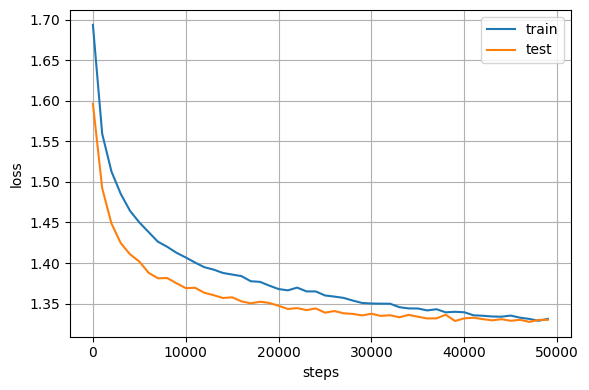

In [59]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, train_losses, label="train")
plt.plot(steps, test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simple LUT transformer

In [8]:
from spiky.lut.LUTLayer import GradientPolicy, GradientType
from spiky.lut.LUTTransformer import LUTTransformer
lut_transformer = None
optimizer = None
sched = None
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
lut_transformer = LUTTransformer(
    vocab_size=256,
    embedding_dim=32,
    context_size=CONTEXT_SIZE,
    positional_dim=4,
    num_layers=6,
    num_heads=4,
    n_detectors=16,
    n_anchors_per_detector=6,
    weights_gradient_policy=GradientPolicy(GradientType.Internal),
    device=device,
    seed=None,
    _forward_group_size=32,
    _backward_group_size=256
)
print(lut_transformer)

LUTTransformer(
  (token_embedder): Embedding(256, 32)
  (layers): ModuleList(
    (0-5): 6 x ModuleDict(
      (attention_lut): LUTLayer(32 inputs, 64 detectors, 32 outputs, 6 anchors per detector)
      (ffn): LUTLayer(32 inputs, 16 detectors, 32 outputs, 6 anchors per detector)
    )
  )
  (unembedder): LUTLayer(32 inputs, 16 detectors, 256 outputs, 6 anchors per detector)
)


In [9]:
total = sum(p.numel() for p in lut_transformer.parameters())
trainable = sum(p.numel() for p in lut_transformer.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 805820928
trainable: 805812736
frozen: 8192


In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

optimizer = optim.SGD(lut_transformer.parameters(), lr=0.1)
sched = LambdaLR(optimizer, lr_lambda=lr_func)
lut_transformer.set_external_learning_rate_hook(make_lr_getter(optimizer))
# optimizer = optim.Adam(lut_net.parameters(), lr=0.001)

In [11]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD

batch_size = 128

def generate_text_lut(lut_model, prefix, length, device):
    ctx = list(prefix.encode("utf-8"))
    ctx = ctx[-CONTEXT_SIZE:]

    for _ in range(length):
        x = torch.zeros([CONTEXT_SIZE], dtype=torch.long, device=device).unsqueeze(0)
        trunc_ctx = ctx[-CONTEXT_SIZE:]
        x[0, -len(trunc_ctx):] = torch.tensor(trunc_ctx, dtype=torch.long, device=device) 
        logits = lut_model(x)
        probs = torch.softmax(logits[:,-1,:], dim=-1)[0]
        next_id = torch.multinomial(probs, 1).item()
        ctx.append(next_id)

    ctx_safe = [c if c != 0 else 32 for c in ctx]
        
    return bytes(ctx_safe).decode("latin1", errors="ignore")

def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in sampler.testing_batches_iterator(B):   # [B, C]
            inp = batch[:, :-1]          # [B, C-1]
            tgt = batch[:, 1:].long()    # [B, C-1]

            logits = model(inp)   # [B, C-1, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_ * T, V),
                tgt.reshape(B_ * T)
            )
            losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text_lut(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses) #  / (CONTEXT_SIZE * B)

In [12]:
steps=50000
test_every=1000
lut_train_losses = []
lut_test_losses = []
train_loss = None
alpha = 0.01

pbar = tqdm(total=steps)
lut_transformer.train()

for step in range(1, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    inp = x[:, :-1]                                         # [B, C-1]
    tgt = x[:, 1:].long()                                   # [B, C-1]

    logits = lut_transformer(inp)      # [B, C-1, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B * T, V),
        tgt.reshape(B * T),
        reduction='none'
    ).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    sched.step()

    loss_value = loss.item() / (CONTEXT_SIZE * batch_size)
    train_loss = loss_value if train_loss is None else (1 - alpha) * train_loss + alpha * loss_value
    pbar.update(1)
    if step % 10 == 0:
        pbar.set_description(f"loss={train_loss:.4f}, lr {sched.get_last_lr()[0]:.4f}")

    if step % test_every == 0:
        test_loss = evaluate_model(lut_transformer, snippet_sampler, batch_size)
        lut_train_losses.append(train_loss)
        lut_test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/50000 [00:00<?, ?it/s]


[GEN]: Once upon a time whatrs
Old ge earth,
Whµ is Ãwand couriered shay rway¹fe, uurtougidder m¡Zfy 

[TEST] step 1000: loss=1.9844

[GEN]: Once upon a time to am thands I leat theer of on,
At what, but bound parmpiend in a oucar commend 

[TEST] step 2000: loss=1.7155

[GEN]: Once upon a time tome
tho hit, to make wardly touch.

GREGORY:
T D sick, I low my graciousanding  

[TEST] step 3000: loss=1.6388

[GEN]: Once upon a time inleret,
Fortunic
Fake pursing uptitor: speak
Of hether bail it that know Bong o 

[TEST] step 4000: loss=1.6424

[GEN]: Once upon a time to wond in anter
Than in the froulded mist.
A die.

First Citizen:
'Tis wortes;  

[TEST] step 5000: loss=1.6485

[GEN]: Once upon a time and holes her, go just,
Our prince,
What consence makes this death to hath be no 

[TEST] step 6000: loss=1.6664


KeyboardInterrupt: 

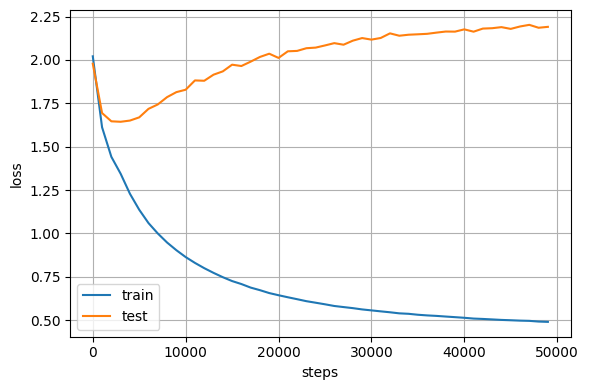

In [76]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

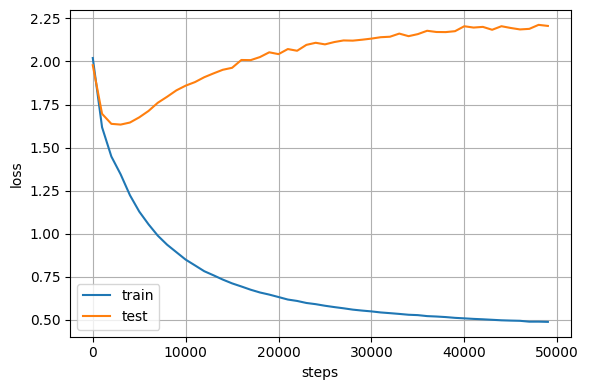

In [14]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

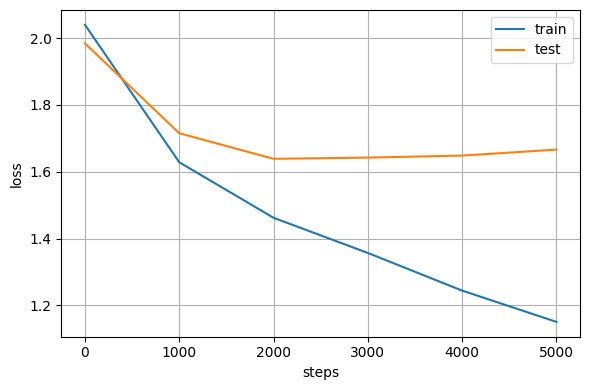

In [13]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
generate_text_lut(lut_transformer, 'Once upon a time: ', length=80, device=device)

In [ ]:
(685.8 / 2308) * 2132 + 50.6 + 70.2

In [ ]:
print(lut_transformer.layers[0]['attention_lut'].get_profiling_stats())

In [ ]:
print(lut_transformer.get_profile_statistics())

In [ ]:
print(lut_transformer.get_profile_statistics())

In [ ]:
evaluate_model(lut_transformer, snippet_sampler, 4)

In [ ]:
print(lut_transformer.layers[1]['attention_lut'].get_profiling_stats())

In [ ]:
print(lut_transformer.layers[3]['attention_lut'].get_profiling_stats())

In [ ]:
print(lut_transformer.unembedder.get_profiling_stats())

In [ ]:
ctx = list('Once upon a time '.encode("utf-8"))
ctx = ctx[-CONTEXT_SIZE:]

for _ in range(20):
    x = torch.zeros([CONTEXT_SIZE], dtype=torch.long, device=device).unsqueeze(0)
    x[0, -len(ctx):] = torch.tensor(ctx, dtype=torch.long, device=device) 
    logits = lut_transformer(x)
    probs = torch.softmax(logits[:,-1,:], dim=-1)[0]
    next_id = torch.multinomial(probs, 1).item()
    ctx.append(next_id)
    ctx = ctx[-CONTEXT_SIZE:]

In [ ]:
bytes(ctx).decode("latin1", errors="ignore")

In [ ]:
logits.shape

In [ ]:
9.536752259018191 / 10000000


In [ ]:
0.0000009